# Stock Price Prediction with LSTM

In this notebook, we demonstrate how to:
- Download stock data
- Preprocess it using sliding windows
- Train an LSTM model to predict the next day's closing price
- Evaluate the model
- Visualize predictions against actual prices

## Step 1: Setup and Imports

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import numpy as np

import sys
import os
sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
from models.lstm_model import LSTMModel
from data.fetch_data import download_stock_data
from utils.preprocess import preprocess
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Step 2: Load and Preprocess Data

In [4]:
# Hyperparameters
WINDOW_SIZE = 60

# Download and prepare data
stock_df = download_stock_data("AAPL", start_date="2020-01-01", end_date="2023-01-01")
X, y, scaler = preprocess(stock_df, window_size=WINDOW_SIZE)

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split into training and testing
split = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split], X_tensor[split:]
y_train, y_test = y_tensor[:split], y_tensor[split:]

/Users/haozhen/Desktop/finsight/backend/data/fetch_data.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


## Step 3: Load Trained LSTM Model

In [5]:
model = LSTMModel(hidden_size=50, num_layers=2, dropout=0.2)
model.load_state_dict(torch.load("../models/trained_lstm_model.pth"))
model.eval()

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

## Step 4: Make Predictions

In [6]:
with torch.no_grad():
    predicted = model(X_test)
    predicted_np = scaler.inverse_transform(predicted.numpy())
    actual_np = scaler.inverse_transform(y_test.numpy())

## Step 5: Plot Predictions

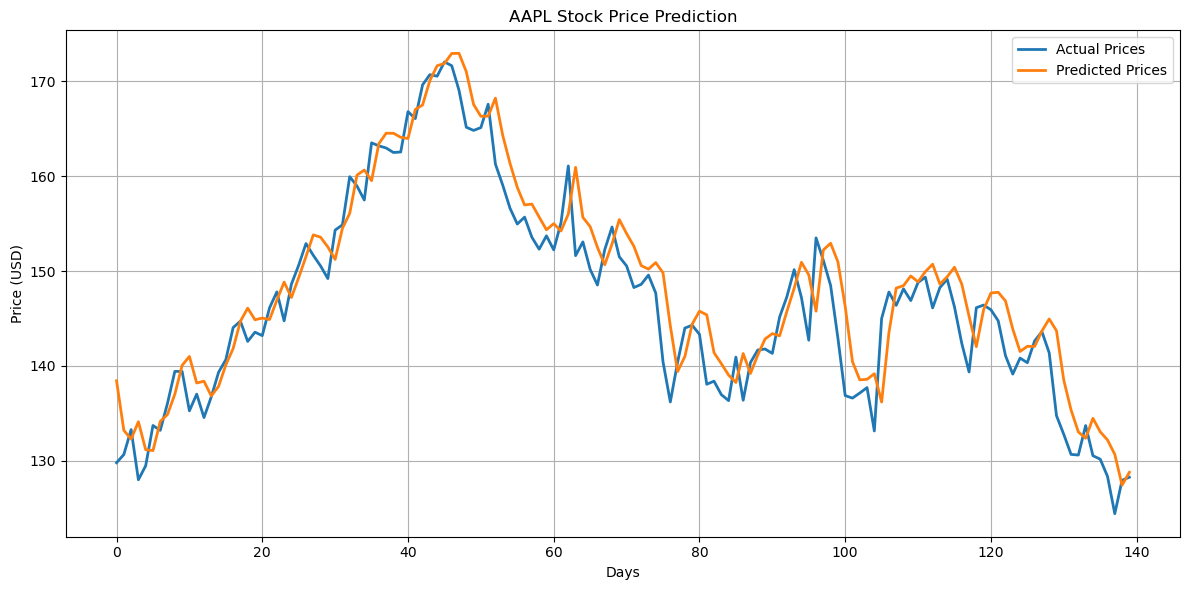

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(actual_np, label='Actual Prices', linewidth=2)
plt.plot(predicted_np, label='Predicted Prices', linewidth=2)
plt.title("AAPL Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Residual Error plot

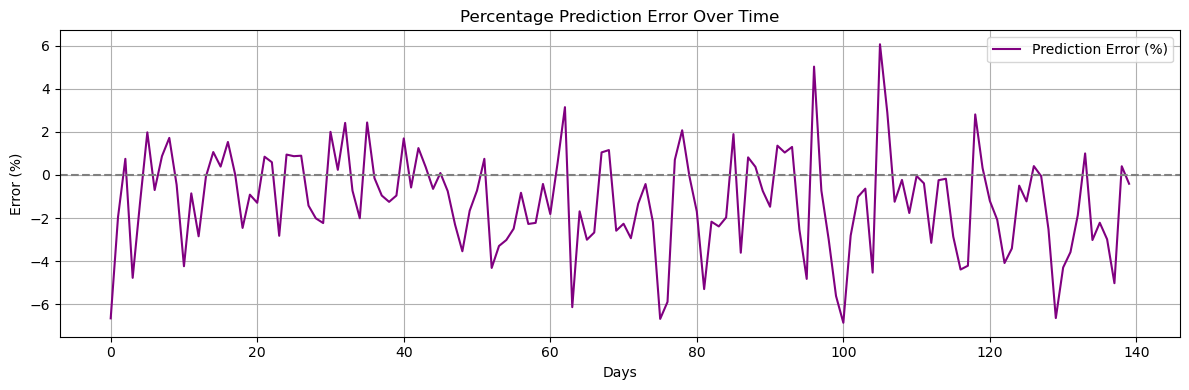

In [12]:
residuals_pct = (residuals / actual_np.flatten()) * 100
plt.figure(figsize=(12, 4))
plt.plot(residuals_pct, label='Prediction Error (%)', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Percentage Prediction Error Over Time')
plt.xlabel("Days")
plt.ylabel("Error (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluation Metrics and Baseline Comparison

In [16]:
mse = mean_squared_error(actual_np, predicted_np)
mae = mean_absolute_error(actual_np, predicted_np)
r2 = r2_score(actual_np, predicted_np)

print(f"LSTM Model Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Naive baseline: predict today's price as yesterday's
naive_preds = actual_np[:-1]
naive_actuals = actual_np[1:]
naive_mse = mean_squared_error(naive_actuals, naive_preds)
print(f"\nNaive Baseline MSE: {naive_mse:.4f}")

LSTM Model Metrics:
MSE: 13.9529
MAE: 2.9430
R² Score: 0.8806

Naive Baseline MSE: 10.3797


## Rolling Forecast

In [19]:
rolling_preds = []
input_seq = X_test[0].unsqueeze(0)  # initial 60-day window

for _ in range(len(X_test)):
    with torch.no_grad():
        pred = model(input_seq)
    rolling_preds.append(pred.item())

    # append prediction to window and remove oldest step
    next_step = pred.reshape(1, 1, 1)
    next_input = torch.cat((input_seq[:, 1:, :], next_step), dim=1)
    input_seq = next_input

rolling_preds_np = scaler.inverse_transform(np.array(rolling_preds).reshape(-1, 1))

## Comparing rolling predictions with actual prices and direct predictions

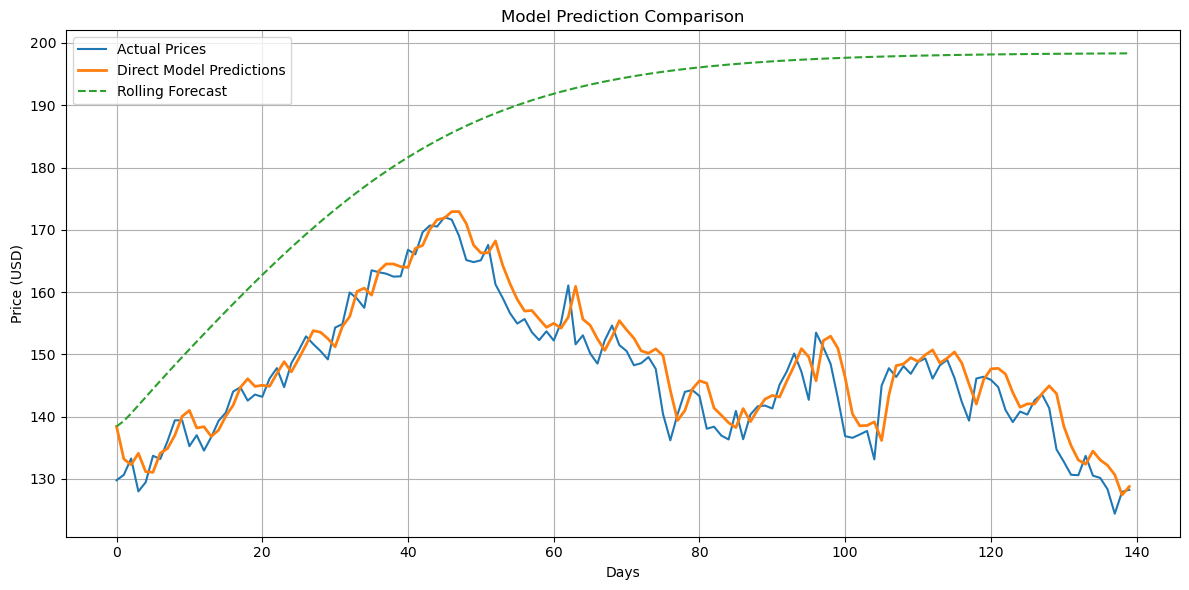

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(actual_np, label='Actual Prices')
plt.plot(predicted_np, label='Direct Model Predictions', linewidth=2)
plt.plot(rolling_preds_np, label='Rolling Forecast', linestyle='--')
plt.title("Model Prediction Comparison")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Direct Prediction vs Rolling Forecast (Conceptual Overview)
**Direct Single-Step Prediction**:
- Predicts the next day's price from the last 60 days.
- All predictions are made independently using actual input windows.
- Assumes access to ground-truth sequences.
- Also known as **one-step-ahead supervised forecasting**.

**Rolling Forecast**:
- Starts with the first known 60-day window.
- Each new prediction is appended to the input and used for the next prediction.
- Simulates real-world inference when future data is unavailable.
- Subject to error accumulation.

### Direct Prediction
- Pros:
  - More accurate (uses ground truth inputs)
  - Great for training and initial benchmarking
- Cons:
  - Unrealistic during live forecasting (can’t peek at real future)

### Rolling Forecast
- Pros:
  - Realistic simulation of deployment
  - Captures drift and feedback issues
- Cons:
  - Prone to compound errors
  - Typically less accurate than direct prediction